<h1 style='color:rgb(144, 12, 63)'; align=center><font size = 8> Analyzing Manitoba Crop Yield by Municipality </font></h1>

<h2 style='color:rgb(144, 12, 63)'; align=left><font size = 6> Notebook 1 - Data Mining and ETL </font></h2>

This notebook describes the following steps:

1. How the data was obtained, and any filters or queries used in generating the data sets
2. The steps taken in ETL to create a data set that is [Tidy compliant](https://about.dataclassroom.com/blog/keep-your-data-tidy)
3. Identification of missing values
4. Validation that all data is [Tidy compliant](https://about.dataclassroom.com/blog/keep-your-data-tidy) by performing preliminary visualizations

# REQUIRED LIBRARIES

The following libraries are required to run this notebook:

In [1]:
# Library to find and identify missing values
import missingno as msno 

In [2]:
# Library to create interactive tools
import ipywidgets as widgets

In [3]:
# Library to create tabular data
import pandas as pd

In [4]:
# Library to create tabular data for geo-analysis
import geopandas as gpd

In [5]:
# Library used to create maps in Python
import folium

# DATA MINING

This section details how the data for this analysis was acquired. There are two primary data sources:

1. [Manitoba Farming Municipalities](https://geoportal.gov.mb.ca/datasets/8b64285c3bf6445a8d0d8ea4a1c43849/explore?location=49.095111%2C-94.536128%2C5.90)
2. [Manitoba Yield by Soil Type](https://www.masc.mb.ca/masc.nsf/mmpp_browser_soil_types.html) using the following filters:

| Description        | Filter                                                                                                               |
|:-------------------|:---------------------------------------------------------------------------------------------------------------------|
| Crops              | ALFALFA, ARGENTINE CANOLA, BARLEY, CANARYSEED, DURUM WHEAT, FABABEANS, FIELD PEAS, FLAX, LENTILS, OATS, WINTER WHEAT |
| Soils              | All soils type                                                                                                       |
| Year Range         | From 2002 to 2022                                                                                                    |

## DATA SETS

The resulting datasets acquired through this process are:

> manitobaYieldData_2022.xlsx (crop yields)

> MG_MUNICIPALITY_POLY.shp (municipalities)

These datasets are located in the `Data` folder, in the local repository. 

## INSPECTING THE DATA SETS

The following scripts will load the data sets for inspection.

### DATA PATH

In [6]:
# The path to the Manitoba Cropy Yield data
dataPath_manitobaCropYield = "./../Data/Manitoba/manitobaYieldData_2022.xlsx"

In [7]:
# The path to the Manitoba municipalities
dataPath_manitobaMunicipalities = "./../Data/Manitoba/manitobaMunicipalities/MG_MUNICIPALITY_POLY.shp"

### LOADING MANITOBA CROP YIELD DATA SET

In [8]:
# Load the dataset into memory
manitobaCropYield_df = pd.read_excel(dataPath_manitobaCropYield)

manitobaCropYield_df

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/acre(Metric),Yield/acre(Metric).1,Yield/acre(Imperial)
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452 Tonnes,Tonnes,997 Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449 Tonnes,Tonnes,991 Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449 Tonnes,Tonnes,990 Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444 Tonnes,Tonnes,980 Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439 Tonnes,Tonnes,968 Pounds
...,...,...,...,...,...,...,...,...,...
61039,2022,YELLOWHEAD,BARLEY,F,Below,Minimum,Tolerance,NaN,NaN
61040,2022,YELLOWHEAD,FIELD PEAS,D,Below,Minimum,Tolerance,NaN,NaN
61041,2022,YELLOWHEAD,FLAX,B,Below,Minimum,Tolerance,NaN,NaN
61042,2022,YELLOWHEAD,FLAX,C,Below,Minimum,Tolerance,NaN,NaN


In [9]:
# Preliminary dataset inspection
manitobaCropYield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61044 entries, 0 to 61043
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year                  61044 non-null  int64 
 1   Risk Area / R.M.      61044 non-null  object
 2   Crop                  61044 non-null  object
 3   Soil                  61044 non-null  object
 4   Farms                 61044 non-null  object
 5   Acres                 61044 non-null  object
 6   Yield/acre(Metric)    61044 non-null  object
 7   Yield/acre(Metric).1  24887 non-null  object
 8   Yield/acre(Imperial)  24887 non-null  object
dtypes: int64(1), object(8)
memory usage: 4.2+ MB


#### DATA OBSERVATIONS

According to the the [Manitoba Agriculture Services Corporation](https://www.masc.mb.ca/masc.nsf/mmpp_browser_soil_types.html), the following definition applies to `Below Minimum Tolerance`:

> `Below Minimum Tolerance` **records contain data from fewer than 3 producers or 500 acres, marked as such to retain producer anonymity. Data from these records is included in the Search Summary totals.**

Below is the result of inspecting the `Farms` feature:

In [10]:
# Inspecting the Farms feature
manitobaCropYield_df['Farms'].describe()

count     61044
unique      134
top       Below
freq      36157
Name: Farms, dtype: object

It appears that `Below` appears to be a significant component of this data set. Inspecting the other two relevant features reveals the following:

In [11]:
# Inspecting the Acres feature
manitobaCropYield_df['Acres'].describe()

count       61044
unique       8059
top       Minimum
freq        36157
Name: Acres, dtype: object

In [12]:
# Inspecting the Farms feature
manitobaCropYield_df['Yield/acre(Metric)'].describe()

count         61044
unique         2468
top       Tolerance
freq          36157
Name: Yield/acre(Metric), dtype: object

It also appears that all `NaN` values are related to features that have `Below Minimum Tolerance`. Therefore, let's remove these records from our dataset. 

In order for this data set to be [Tidy compliant](https://about.dataclassroom.com/blog/keep-your-data-tidy), the following operations need to be performed:

1. Delete all records related to `Below Minimum Tolerance`
2. Transform `Farms` so that all values are numerical
3. Transform `Acres` so that all values are numerical
4. Transform `Yield/acre(Metric)` so that all values are numerical

### LOADING MANITOBA MUNICIPALITIES DATA SET

In [13]:
manitobaMunicipalities_gdf = gpd.read_file(dataPath_manitobaMunicipalities)

manitobaMunicipalities_gdf

,OBJECTID,MUNI_NO,MUNI_NAME,MUNI_TYPE,MUNI_LIST_,MUNI_LIS_1,SHAPE_Leng,SHAPE_Area,geometry
0,1,189,RM OF SPRINGFIELD,RM,SPRINGFIELD,SPRINGFIELD (RM),269137.502684,2.601484e+09,"POLYGON ((-10757459.464 6456526.821, -10757468..."
1,2,102,RM OF ARGYLE,RM,ARGYLE,ARGYLE (RM),206734.856979,1.909429e+09,"POLYGON ((-11060718.858 6365771.762, -11060672..."
2,3,169,RM OF ROLAND,RM,ROLAND,ROLAND (RM),136057.890202,1.142975e+09,"POLYGON ((-10879342.025 6350468.886, -10879339..."
3,4,151,RM OF MONTCALM,RM,MONTCALM,MONTCALM (RM),225875.089147,1.103741e+09,"POLYGON ((-10837073.626 6335234.827, -10836852..."
4,5,540,CITY OF FLIN FLON,CITY,FLIN FLON,FLIN FLON (CITY),44756.134618,-7.264277e+07,"MULTIPOLYGON (((-11341354.484 7317922.661, -11..."
...,...,...,...,...,...,...,...,...,...
178,179,357,VILLAGE OF ST. PIERRE-JOLYS,VILLAGE,ST PIERRE-JOLYS,ST PIERRE-JOLYS (VILLAGE),10070.968003,6.029750e+06,"POLYGON ((-10797902.480 6349510.413, -10797904..."
179,180,710,NORWAY HOUSE-NORTHERN AFFAIRS ACT,NORTHERN COMMUNITY,NORWAY HOUSE,NORWAY HOUSE (NORTHERN COMMUNITY),137865.738231,6.121886e+08,"POLYGON ((-10893765.150 7179606.333, -10893746..."
180,181,712,PIKWITONEI-NORTHERN AFFAIRS ACT,NORTHERN COMMUNITY,PIKWITONEI,PIKWITONEI (NORTHERN COMMUNITY),33744.671965,2.377594e+07,"MULTIPOLYGON (((-10817895.865 7479353.767, -10..."
181,182,730,ROCK RIDGE-NORTHERN AFFAIRS ACT,NORTHERN COMMUNITY,ROCK RIDGE,ROCK RIDGE (NORTHERN COMMUNITY),7868.907648,2.183517e+06,"POLYGON ((-11084093.307 6784800.867, -11084101..."


In [14]:
# Preliminary dataset inspection
manitobaMunicipalities_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    183 non-null    int64   
 1   MUNI_NO     183 non-null    int64   
 2   MUNI_NAME   183 non-null    object  
 3   MUNI_TYPE   183 non-null    object  
 4   MUNI_LIST_  183 non-null    object  
 5   MUNI_LIS_1  183 non-null    object  
 6   SHAPE_Leng  183 non-null    float64 
 7   SHAPE_Area  183 non-null    float64 
 8   geometry    183 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 13.0+ KB


<Axes: >

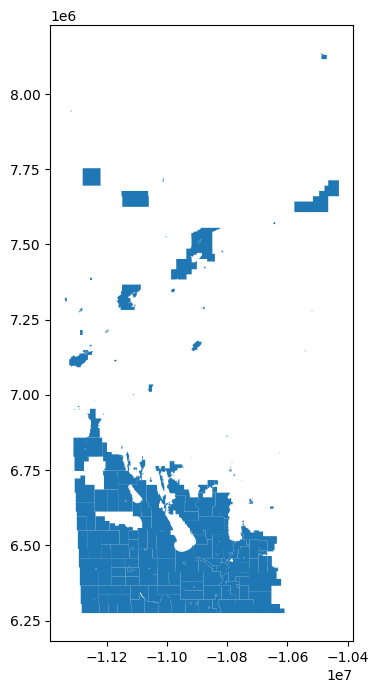

In [15]:
# Preliminary dataset inspection
manitobaMunicipalities_gdf.plot(
    figsize = (10, 8)
)   

#### DATA OBSERVATIONS

According to the initial data set inspection, this data appears ok as-is.

# ETL DATA SET

ETL is only required on the `manitobaCropYield_df` data set.

## MANITOBA CROP YIELD - DATA SET

The following ETL operations are required on this data set:

1. [X] Delete all records related to `Below Minimum Tolerance`
2. [X] Rename fields:

   >  `Yield/acre(Metric)` to `Yield/Acre Metric`
   
   > `Yield/acre(Metric).1`, to `UOM in Metric`
   
   > `Yield/acre(Imperial)` to `Yield/Acre Imperial`

3. [X] Create new column name  `UOM in Imperial`
4. [X] Transform `Yield/Acre Metric` to a numerical field
5. [X] Transform `Yield/Acre Imperial` to a numerical field, move UOM to `UOM in Imperial`
6. [X] Transform `Acres` to a numerical field
7. [ ] Transform `Farms` to a numerical field

Below are the steps to complete each task:

### DELETE `Below Minimum Tolerance`

The operation to perform this step is below:

In [16]:
# Drop all the columns related to `Below Minimum Tolerance`. This step also removes missing values from the data set
manitobaCropYield_tdf_1 = manitobaCropYield_df[manitobaCropYield_df['Farms'] != 'Below']

manitobaCropYield_tdf_1

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/acre(Metric),Yield/acre(Metric).1,Yield/acre(Imperial)
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452 Tonnes,Tonnes,997 Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449 Tonnes,Tonnes,991 Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449 Tonnes,Tonnes,990 Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444 Tonnes,Tonnes,980 Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439 Tonnes,Tonnes,968 Pounds
...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345 Tonnes,Tonnes,0.381 Tons
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302 Tonnes,Tonnes,0.332 Tons
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007 Tonnes,Tonnes,0.3 Bushels
24885,2021,HANOVER,ALFALFA,E,5,543,0.233 Tonnes,Tonnes,0.257 Tons


In [17]:
# Inspect the columns for missing values
manitobaCropYield_tdf_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24887 entries, 0 to 24886
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year                  24887 non-null  int64 
 1   Risk Area / R.M.      24887 non-null  object
 2   Crop                  24887 non-null  object
 3   Soil                  24887 non-null  object
 4   Farms                 24887 non-null  object
 5   Acres                 24887 non-null  object
 6   Yield/acre(Metric)    24887 non-null  object
 7   Yield/acre(Metric).1  24887 non-null  object
 8   Yield/acre(Imperial)  24887 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.9+ MB


### RENAMING FIELDS

To rename these fields, a dictionary needs to be created:

In [18]:
# Dictionary of fields to be renamed
renamedColumns_dict = {
    'Yield/acre(Metric)' : 'Yield/Acre Metric',
    'Yield/acre(Metric).1' : 'UOM in Metric',
    'Yield/acre(Imperial)' : 'Yield/Acre Imperial'
}   

In [19]:
# Update columns
manitobaCropYield_tdf_2 = manitobaCropYield_tdf_1.rename(columns = renamedColumns_dict)

manitobaCropYield_tdf_2

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/Acre Metric,UOM in Metric,Yield/Acre Imperial
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452 Tonnes,Tonnes,997 Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449 Tonnes,Tonnes,991 Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449 Tonnes,Tonnes,990 Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444 Tonnes,Tonnes,980 Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439 Tonnes,Tonnes,968 Pounds
...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345 Tonnes,Tonnes,0.381 Tons
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302 Tonnes,Tonnes,0.332 Tons
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007 Tonnes,Tonnes,0.3 Bushels
24885,2021,HANOVER,ALFALFA,E,5,543,0.233 Tonnes,Tonnes,0.257 Tons


### CREATE NEW COLUMN NAMED `UOM Imperial`

The following step creates this new feature:

In [20]:
# Create a new empty feature
manitobaCropYield_tdf_2['UOM Imperial'] = ''

manitobaCropYield_tdf_2

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/Acre Metric,UOM in Metric,Yield/Acre Imperial,UOM Imperial
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452 Tonnes,Tonnes,997 Pounds,
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449 Tonnes,Tonnes,991 Pounds,
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449 Tonnes,Tonnes,990 Pounds,
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444 Tonnes,Tonnes,980 Pounds,
4,2002,ROLAND,CANARYSEED,D,6,981,0.439 Tonnes,Tonnes,968 Pounds,
...,...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345 Tonnes,Tonnes,0.381 Tons,
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302 Tonnes,Tonnes,0.332 Tons,
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007 Tonnes,Tonnes,0.3 Bushels,
24885,2021,HANOVER,ALFALFA,E,5,543,0.233 Tonnes,Tonnes,0.257 Tons,


### TRANSFORM `Yield/Acre Metric`

The following steps are used to inspect and plan how to transform this feature.

In [21]:
# Inspect the values found in this column
manitobaCropYield_tdf_2['Yield/Acre Metric'].value_counts()

Yield/Acre Metric
0.906 Tonnes    35
0.874 Tonnes    35
0.708 Tonnes    33
0.919 Tonnes    32
0.620 Tonnes    30
                ..
2.455 Tonnes     1
1.998 Tonnes     1
2.428 Tonnes     1
2.412 Tonnes     1
0.000 Tonnes     1
Name: count, Length: 2467, dtype: int64

In [22]:
# Inspect the values in this column
manitobaCropYield_tdf_2['UOM in Metric'].value_counts()

UOM in Metric
Tonnes    24887
Name: count, dtype: int64

It appears that `Tonnes` is the only value in `Yield/Acre Metric`, and is the only value in `UOM in Metric`. Therefore; the conversion of `Yield/Acre Metric` to numerical is a simple process. Below are the steps:

In [23]:
# Create a copy of the data set
manitobaCropYield_tdf_3 = manitobaCropYield_tdf_2.copy()

In [24]:
# Transform the feature to a numerical one
manitobaCropYield_tdf_3['Yield/Acre Metric'] = manitobaCropYield_tdf_3['Yield/Acre Metric'].str.replace(' Tonnes', '').astype(float)

manitobaCropYield_tdf_3

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/Acre Metric,UOM in Metric,Yield/Acre Imperial,UOM Imperial
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452,Tonnes,997 Pounds,
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449,Tonnes,991 Pounds,
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449,Tonnes,990 Pounds,
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444,Tonnes,980 Pounds,
4,2002,ROLAND,CANARYSEED,D,6,981,0.439,Tonnes,968 Pounds,
...,...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345,Tonnes,0.381 Tons,
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302,Tonnes,0.332 Tons,
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007,Tonnes,0.3 Bushels,
24885,2021,HANOVER,ALFALFA,E,5,543,0.233,Tonnes,0.257 Tons,


In [25]:
# Verify the transformation was succesful
manitobaCropYield_tdf_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24887 entries, 0 to 24886
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 24887 non-null  int64  
 1   Risk Area / R.M.     24887 non-null  object 
 2   Crop                 24887 non-null  object 
 3   Soil                 24887 non-null  object 
 4   Farms                24887 non-null  object 
 5   Acres                24887 non-null  object 
 6   Yield/Acre Metric    24887 non-null  float64
 7   UOM in Metric        24887 non-null  object 
 8   Yield/Acre Imperial  24887 non-null  object 
 9   UOM Imperial         24887 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 2.1+ MB


### TRANSFORM `Yield/Acre Imperial`

The following steps are used to inspect and plan how to transform this feature.

In [26]:
# Inspect the values in the column
manitobaCropYield_tdf_3['Yield/Acre Imperial'].value_counts()

Yield/Acre Imperial
30.3 Bushels    63
43.9 Bushels    60
41.2 Bushels    59
31.2 Bushels    58
42.6 Bushels    58
                ..
3.597 Tons       1
3.596 Tons       1
3.593 Tons       1
3,584 Pounds     1
0.0 Bushels      1
Name: count, Length: 2128, dtype: int64

In [27]:
# Copy the values to another feature
manitobaCropYield_tdf_3['UOM Imperial'] = manitobaCropYield_tdf_3['Yield/Acre Imperial']

manitobaCropYield_tdf_3

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/Acre Metric,UOM in Metric,Yield/Acre Imperial,UOM Imperial
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452,Tonnes,997 Pounds,997 Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449,Tonnes,991 Pounds,991 Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449,Tonnes,990 Pounds,990 Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444,Tonnes,980 Pounds,980 Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439,Tonnes,968 Pounds,968 Pounds
...,...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345,Tonnes,0.381 Tons,0.381 Tons
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302,Tonnes,0.332 Tons,0.332 Tons
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007,Tonnes,0.3 Bushels,0.3 Bushels
24885,2021,HANOVER,ALFALFA,E,5,543,0.233,Tonnes,0.257 Tons,0.257 Tons


In [28]:
# Remove non-numeric parts and convert to float
manitobaCropYield_tdf_3['Yield/Acre Imperial'] = manitobaCropYield_tdf_3['Yield/Acre Imperial'].str.replace(
    '[^\d\.]', 
    '', 
    regex = True
).str.replace(',', '.').astype(float)

manitobaCropYield_tdf_3

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/Acre Metric,UOM in Metric,Yield/Acre Imperial,UOM Imperial
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452,Tonnes,997.000,997 Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449,Tonnes,991.000,991 Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449,Tonnes,990.000,990 Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444,Tonnes,980.000,980 Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439,Tonnes,968.000,968 Pounds
...,...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345,Tonnes,0.381,0.381 Tons
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302,Tonnes,0.332,0.332 Tons
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007,Tonnes,0.300,0.3 Bushels
24885,2021,HANOVER,ALFALFA,E,5,543,0.233,Tonnes,0.257,0.257 Tons


In [29]:
# Remove numeric values and whitespace
manitobaCropYield_tdf_3['UOM Imperial']= manitobaCropYield_tdf_3['UOM Imperial'].str.replace(
    '[\d\.,]', 
    '', 
    regex = True
).str.strip()

manitobaCropYield_tdf_3

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/Acre Metric,UOM in Metric,Yield/Acre Imperial,UOM Imperial
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452,Tonnes,997.000,Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449,Tonnes,991.000,Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449,Tonnes,990.000,Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444,Tonnes,980.000,Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439,Tonnes,968.000,Pounds
...,...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345,Tonnes,0.381,Tons
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302,Tonnes,0.332,Tons
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007,Tonnes,0.300,Bushels
24885,2021,HANOVER,ALFALFA,E,5,543,0.233,Tonnes,0.257,Tons


In [30]:
# Confirm transformations were succesful
manitobaCropYield_tdf_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24887 entries, 0 to 24886
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 24887 non-null  int64  
 1   Risk Area / R.M.     24887 non-null  object 
 2   Crop                 24887 non-null  object 
 3   Soil                 24887 non-null  object 
 4   Farms                24887 non-null  object 
 5   Acres                24887 non-null  object 
 6   Yield/Acre Metric    24887 non-null  float64
 7   UOM in Metric        24887 non-null  object 
 8   Yield/Acre Imperial  24887 non-null  float64
 9   UOM Imperial         24887 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.1+ MB


In [31]:
# Verify the values to confirm success
manitobaCropYield_tdf_3['UOM Imperial'].value_counts()

UOM Imperial
Bushels    24255
Tons         415
Pounds       217
Name: count, dtype: int64

### TRANSFORM `Acres`

The following steps are used to inspect and plan how to transform this feature.

In [32]:
# Extract the feature into a list
acres_list = manitobaCropYield_tdf_3['Acres'].to_list()

In [33]:
# Create an empty list that will hold empty values
acresNumberical_list = []

In [34]:
# For loop to convert the values to numerical
for acre in acres_list:
    # Convert the value to integer
    try:
        acre = int(acre)
    except:
        if ',' in acre:
            acre = acre.replace(',', '')
            acre = int(float(acre))
    # Append to new list of converted values
    acresNumberical_list.append(acre)         

In [35]:
# Update the dataframe
manitobaCropYield_tdf_3['Acres'] = acresNumberical_list

manitobaCropYield_tdf_3

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/Acre Metric,UOM in Metric,Yield/Acre Imperial,UOM Imperial
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452,Tonnes,997.000,Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,1180,0.449,Tonnes,991.000,Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449,Tonnes,990.000,Pounds
3,2009,MORRIS,CANARYSEED,D,3,1072,0.444,Tonnes,980.000,Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439,Tonnes,968.000,Pounds
...,...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345,Tonnes,0.381,Tons
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302,Tonnes,0.332,Tons
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007,Tonnes,0.300,Bushels
24885,2021,HANOVER,ALFALFA,E,5,543,0.233,Tonnes,0.257,Tons


In [36]:
# Verify the results
manitobaCropYield_tdf_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24887 entries, 0 to 24886
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 24887 non-null  int64  
 1   Risk Area / R.M.     24887 non-null  object 
 2   Crop                 24887 non-null  object 
 3   Soil                 24887 non-null  object 
 4   Farms                24887 non-null  object 
 5   Acres                24887 non-null  int64  
 6   Yield/Acre Metric    24887 non-null  float64
 7   UOM in Metric        24887 non-null  object 
 8   Yield/Acre Imperial  24887 non-null  float64
 9   UOM Imperial         24887 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 2.1+ MB


### TRANSFORM `Farms`

The following steps are used to inspect and plan how to transform this feature.

In [37]:
manitobaCropYield_tdf_3['Farms'] = manitobaCropYield_tdf_3['Farms'].astype(int)

manitobaCropYield_tdf_3

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/Acre Metric,UOM in Metric,Yield/Acre Imperial,UOM Imperial
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452,Tonnes,997.000,Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,1180,0.449,Tonnes,991.000,Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449,Tonnes,990.000,Pounds
3,2009,MORRIS,CANARYSEED,D,3,1072,0.444,Tonnes,980.000,Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439,Tonnes,968.000,Pounds
...,...,...,...,...,...,...,...,...,...,...
24882,2021,WEST INTERLAKE,ALFALFA,G,10,673,0.345,Tonnes,0.381,Tons
24883,2021,WEST INTERLAKE,ALFALFA,H,14,862,0.302,Tonnes,0.332,Tons
24884,2005,GREY,ARGENTINE CANOLA,E,3,595,0.007,Tonnes,0.300,Bushels
24885,2021,HANOVER,ALFALFA,E,5,543,0.233,Tonnes,0.257,Tons


In [38]:
# Verify the transformation is succesful
manitobaCropYield_tdf_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24887 entries, 0 to 24886
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 24887 non-null  int64  
 1   Risk Area / R.M.     24887 non-null  object 
 2   Crop                 24887 non-null  object 
 3   Soil                 24887 non-null  object 
 4   Farms                24887 non-null  int64  
 5   Acres                24887 non-null  int64  
 6   Yield/Acre Metric    24887 non-null  float64
 7   UOM in Metric        24887 non-null  object 
 8   Yield/Acre Imperial  24887 non-null  float64
 9   UOM Imperial         24887 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 2.1+ MB


# SAVE DATA SET

The following steps saves the data set so that it can be used in the next step.

In [39]:
# The path to the Manitoba Cropy Yield data
dataPath = "./../Data/Manitoba/"

In [40]:
saveName = "manitobaYieldData_2022.csv"

In [41]:
manitobaCropYield_tdf_3.to_csv(
    dataPath + saveName,
    index = False
)